<a href="https://colab.research.google.com/github/tabaraei/depression-detection/blob/master/depression_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Baseline

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [104]:
!git clone https://github.com/lyakaap/NetVLAD-pytorch.git

Cloning into 'NetVLAD-pytorch'...
remote: Enumerating objects: 27, done.
remote: Counting objects: 100% (6/6), done.
remote: Total 27 (delta 5), reused 5 (delta 5), pack-reused 21
Receiving objects: 100% (27/27), 9.26 KiB | 9.26 MiB/s, done.
Resolving deltas: 100% (13/13), done.


In [4]:
import os
import wave
import numpy as np
import librosa
import tensorflow as tf
# import LOUPE_Keras.loupe_keras as lpk

In [5]:
DATA_DIR = '/content/drive/MyDrive/Data/DepressionDetection/EATD-Corpus'
X_train, y_train = list(), list()
X_test, y_test = list(), list()

def load_wave(data_path):
    data_file = wave.open(data_path)
    sr = data_file.getframerate()
    nframes = data_file.getnframes()
    wave_data = np.frombuffer(data_file.readframes(nframes), dtype=np.short).astype(float)
    length = nframes / sr
    return data_file, wave_data, length, nframes, sr

def wav2mel(wave_data, sr):
    cluster_size = 16
    signal = wave_data
    melspec = librosa.feature.melspectrogram(y=signal, sr=sr, n_mels=80).astype(np.float32).T
    melspec = np.log(np.maximum(1e-6, melspec))
    return melspec

for sample in os.listdir(DATA_DIR):
    positive_file, wave_data1, len1, nframes1, sr1 = load_wave(f'{DATA_DIR}/{sample}/positive_out.wav')
    neutral_file, wave_data2, len2, nframes2, sr2 = load_wave(f'{DATA_DIR}/{sample}/neutral_out.wav')
    negative_file, wave_data3, len3, nframes3, sr3 = load_wave(f'{DATA_DIR}/{sample}/negative_out.wav')

    with open(f'{DATA_DIR}/{sample}/new_label.txt') as label:
        target = float(label.readline())

    if wave_data1.shape[0] < 1:
        wave_data1 = np.array([1e-4]*sr1*5)
    if wave_data2.shape[0] < 1:
        wave_data2 = np.array([1e-4]*sr2*5)
    if wave_data3.shape[0] < 1:
        wave_data3 = np.array([1e-4]*sr3*5)

    audio_features = [
        wav2mel(wave_data1, sr1),
        wav2mel(wave_data2, sr2),
        wav2mel(wave_data3, sr3)
    ]
    # targets.append(1 if target >= 53 else 0)

    if sample.startswith('t'):
        # Training Data
        X_train.append(audio_features)
        y_train.append(target)
    else:
        # Test Data
        X_test.append(audio_features)
        y_test.append(target)
    break

print(X_test[0][0].shape)
print(X_test[0][1].shape)
print(X_test[0][2].shape)

(1068, 80)
(1201, 80)
(930, 80)


### Audio File

In [50]:
import torch
import torchaudio

AUDIO_FILE = f'{DATA_DIR}/t_1/positive_out.wav'
metadata = torchaudio.info(AUDIO_FILE)
print(metadata)

AudioMetaData(sample_rate=16000, num_frames=296576, num_channels=2, bits_per_sample=16, encoding=PCM_S)


In [9]:
from IPython.display import Audio
Audio(AUDIO_FILE)

In [8]:
positive_file, wave_data1, len1, nframes1, sr1 = load_wave(AUDIO_FILE)

In [52]:
waveform, sample_rate = torchaudio.load(AUDIO_FILE)

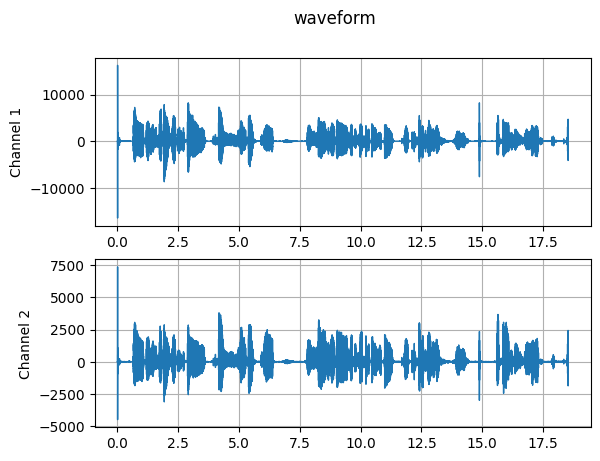

In [46]:
def plot_waveform(waveform, sample_rate):
    waveform = waveform.numpy()
    num_channels, num_frames = waveform.shape
    time_axis = torch.arange(0, num_frames) / sample_rate

    figure, axes = plt.subplots(num_channels, 1)
    if num_channels == 1:
        axes = [axes]
    for c in range(num_channels):
        axes[c].plot(time_axis, waveform[c], linewidth=1)
        axes[c].grid(True)
        if num_channels > 1:
            axes[c].set_ylabel(f"Channel {c+1}")
    figure.suptitle("waveform")

plot_waveform(waveform, sample_rate)

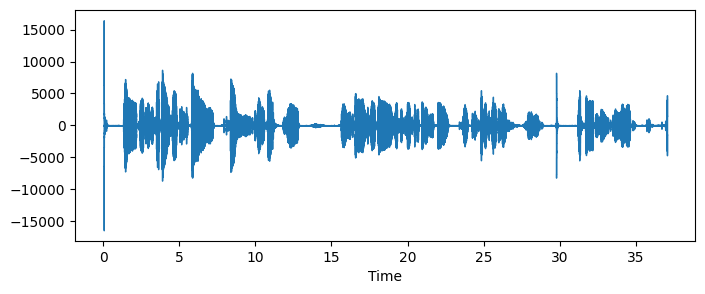

In [49]:
import librosa.display
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 3))
_ = librosa.display.waveshow(wave_data1, sr=sr1)

### Spectogram

In [55]:
def plot_spectrogram(specgram, title=None, ylabel="freq_bin", ax=None):
    if ax is None:
        _, ax = plt.subplots(1, 1)
    if title is not None:
        ax.set_title(title)
    ax.set_ylabel(ylabel)
    ax.imshow(librosa.power_to_db(specgram), origin="lower", aspect="auto", interpolation="nearest")

In [68]:
import torchaudio.transforms as T

mel_spectrogram = T.MelSpectrogram(sample_rate=sample_rate, n_mels=80)
melspec = mel_spectrogram(waveform)

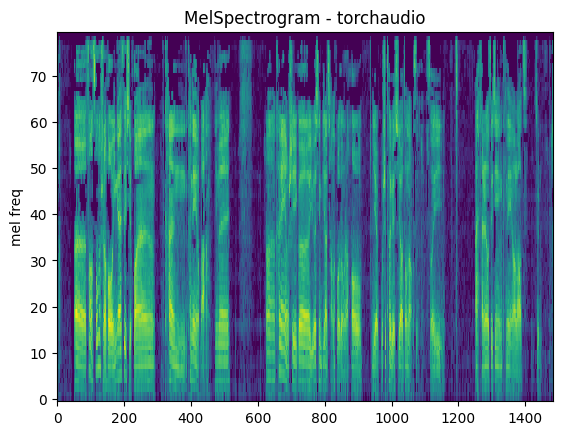

In [69]:
plot_spectrogram(melspec[0], title="MelSpectrogram - torchaudio", ylabel="mel freq")

In [70]:
melspec_librosa = librosa.feature.melspectrogram(
    y=waveform.numpy()[0],
    sr=sample_rate,
    n_mels=80
)

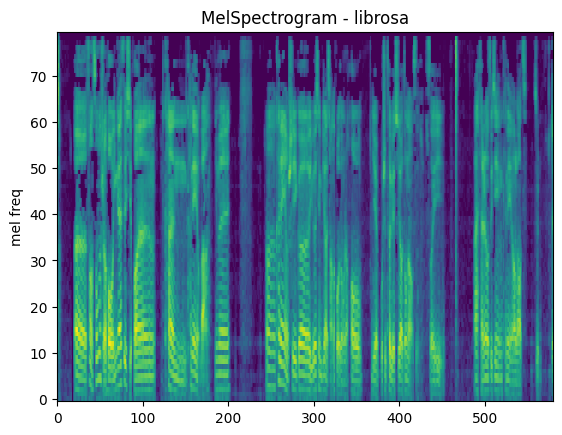

In [71]:
plot_spectrogram(melspec_librosa, title="MelSpectrogram - librosa", ylabel="mel freq")

In [80]:
mel1 = mel_spectrogram(torchaudio.load(f'{DATA_DIR}/t_1/positive_out.wav')[0])
mel2 = mel_spectrogram(torchaudio.load(f'{DATA_DIR}/t_2/positive_out.wav')[0])
print(mel1.shape)
print(mel2.shape)

torch.Size([2, 80, 1483])
torch.Size([2, 80, 327])


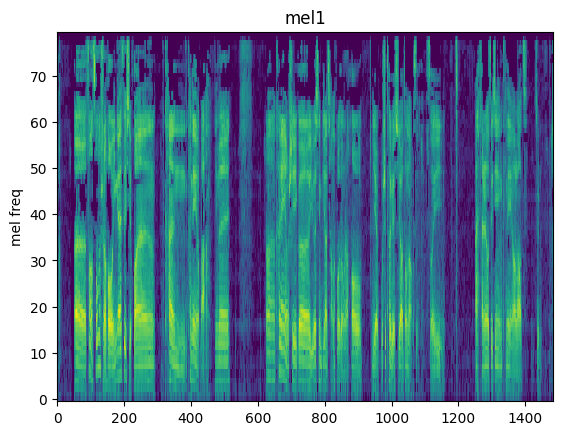

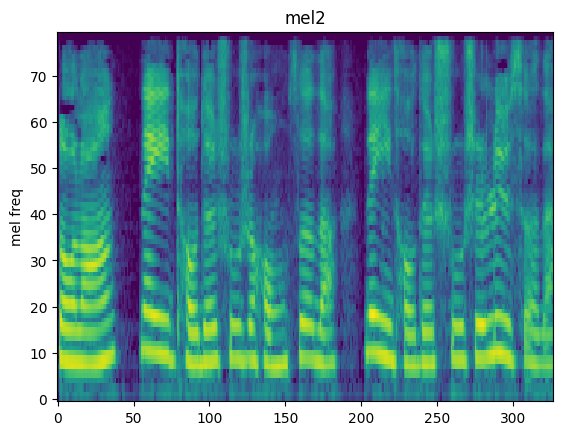

In [82]:
plot_spectrogram(mel1[0], title="mel1", ylabel="mel freq")
plot_spectrogram(mel2[0], title="mel2", ylabel="mel freq")

In [96]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [105]:
mel1.shape

torch.Size([2, 80, 1483])

In [100]:
conv1 = nn.Conv2d(in_channels=2, out_channels=6, kernel_size=5)
x = conv1(mel1)
x.shape

torch.Size([6, 76, 1479])

In [95]:
out_dim = lambda input, filter, padding, stride: ((input-filter + 2*padding)/stride) + 1
out_dim(input=mel1.shape[-2], filter=5, padding=0, stride=1), out_dim(input=mel1.shape[-1], filter=5, padding=0, stride=1)

(76.0, 1479.0)

In [101]:
pool = nn.MaxPool2d(kernel_size=2, stride=2)
x = pool(x)
x.shape

torch.Size([6, 38, 739])

In [102]:
# in_channels are the out_channels of previous step
conv2 = nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5)
x = conv2(x)
x.shape

torch.Size([16, 34, 735])

In [103]:
x = pool(x)
x.shape

torch.Size([16, 17, 367])

In [108]:
torch.flatten(x, 0).shape

torch.Size([99824])

In [109]:
16*17*367

99824

## Model

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms

# Define the CNN architecture
class CNN(nn.Module):
    def __init__(self, num_classes=10):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(128 * 4 * 4, 512)
        self.fc2 = nn.Linear(512, num_classes)

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        x = self.pool(torch.relu(self.conv3(x)))
        x = x.view(-1, 128 * 4 * 4)
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# Define the data loaders and transformations
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4, shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=4, shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

# Initialize the model, loss function, and optimizer
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = CNN(num_classes=len(classes)).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

# Training the model
for epoch in range(2):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data[0].to(device), data[1].to(device)

        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        if i % 2000 == 1999:  # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

print('Finished Training')

# Testing the model
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data[0].to(device), data[1].to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (100 * correct / total))

100%|██████████| 170498071/170498071 [00:02<00:00, 56997282.86it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified
[1,  2000] loss: 2.111
[1,  4000] loss: 1.692
[1,  6000] loss: 1.494
[1,  8000] loss: 1.380
[1, 10000] loss: 1.318
[1, 12000] loss: 1.228
[2,  2000] loss: 1.105
[2,  4000] loss: 1.048
[2,  6000] loss: 1.006
[2,  8000] loss: 0.959
[2, 10000] loss: 0.945
[2, 12000] loss: 0.907
Finished Training
Accuracy of the network on the 10000 test images: 68 %
